The potential $V$ is measured in units of $\frac{\hbar^{2}}{2\mu (1\text{nm})^{2}}$. The oscillator length is $a_{z} = \sqrt{\frac{\hbar}{\mu\omega_{z}}}$, the dipole length is $a_{dd} = \frac{\mu_{0}}{4\pi}(10\mu_{B})^{2}\frac{m}{\hbar^{2}} = \frac{\mu_{0}}{2\pi}(10\mu_{B})^{2}\frac{\mu}{\hbar^{2}} = 20.86 \text{ nm}$ and the Van der Waals length is, as in Julienne's paper (https://journals.aps.org/rmp/pdf/10.1103/RevModPhys.82.1225) $r_{vdw} = \frac{1}{2}\left(2\mu C_{6}/\hbar^{2}\right)^{1/4} = 4.26\text{ nm}$ if I take Nascimbene's paper (https://iopscience.iop.org/article/10.1088/1361-6455/50/1/014005/pdf) where $C_{6} = 2273 E_{h}a_{0}^{6}$.

This transforms the equation:
\[
V(\rho, z) = \frac{1}{2}\mu\omega_{z}^{2}z^{2} + \frac{\hbar^{2}(m^{2}-1/4)}{2\mu\rho^{2}}-\frac{C_{6}}{r^{6}}+\frac{\mu_{0}}{4\pi}(10\mu_{B})^{2}\frac{1-3\cos^{2}\theta}{r^{3}}
\]
into
\[
V(\rho, z) = \frac{V}{\frac{\hbar^{2}}{2\mu (1\text{nm})^{2}}} = \frac{1}{a_{z}^{4}}z^{2} + \frac{m^{2}}{\rho^{2}}-\frac{(2r_{vdw})^{4}}{(z^{2}+\rho^{2})^{3}}+a_{dd}\frac{1-3\frac{z^{2}}{z^{2}+\rho^{2}}}{(z^{2}+\rho^{2})^{3/2}}
\]

In [1]:
from scipy.optimize import root
from scipy.integrate import quad
from scipy.signal import argrelextrema

import numpy as np
import matplotlib.pyplot as plt

In [2]:
hbar = 6.62*10**(-34)/(2*np.pi)
m_Dy = 162*1.66*10**(-27)
k_B = 1.38*10**(-23)
nm_to_uK = hbar**2/(m_Dy*10**(-18)*k_B)*10**6

#a_dd_Dy = 6.96
a_dd_Dy = 10.86
N = 10

In [393]:
matrixCentrifugal(1, 1, 6)

array([[0.375, 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.375, 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.375, 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.375, 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.375, 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.375]])

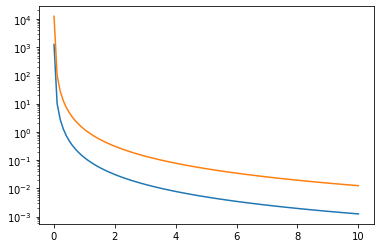

In [400]:
m = 0
Rho = np.linspace(0.01, 10, 100)
centrifugal = []
for rho in Rho:
    centrifugal += [matrixCentrifugal(rho, m, 10)[0, 0]]
centrifugal = np.array(centrifugal)
plt.figure()
plt.semilogy(Rho, -centrifugal)
plt.semilogy(Rho, 10/(8*Rho**2))
plt.show()

In [401]:
def matrixCentrifugal(rho, m, N):
    return np.identity(N)*(m**2-1/4)/(2*rho**2)

def matrixEnergy(E, N):
    return np.identity(N)*E

def matrixHarmonic(N):
    diag = np.array(range(N))
    return np.diag(diag)

def hermite(z, n):
    hermiteFactors = np.zeros(n+1)
    hermiteFactors[n] = 1
    hermite_n = np.polynomial.hermite.Hermite(hermiteFactors)
    return hermite_n(z)

def harmonicOscillatorWF(z, D, n):
    return 1/np.sqrt(2**n*np.math.factorial(n))*np.sqrt(D)*np.pi**(-1/4)*np.exp(-0.5*(z*D)**2)*hermite(z*D, n)

def harmonicOscillatorProba(z, D, n):
    return harmonicOscillatorWF(z, D, n)**2

quad(harmonicOscillator, -np.infty, np.infty, args = (1, 0,))

def dipoleInteraction(z, rho):
    return (1-3*z**2/(z**2+rho**2))/(z**2+rho**2)**(3/2)

def interactionMatrixElement(rho, D, n, nprim):
    def integrant(z, rho, n, nprim):
        return harmonicOscillatorWF(z, D, n)*harmonicOscillatorWF(z, D, nprim)*dipoleInteraction(z, rho)
    return quad(integrant, -np.infty, np.infty, args = (rho, n, nprim))

def interactionMatrix(rho, D, N):
    matrix = np.zeros((N, N))
    for n in range(N):
        for nprim in range(N):
            matrix[n, nprim] = interactionMatrixElement(rho, D, n, nprim)[0]
    return matrix

def nonDiagonalMatrix(rho, D, N):
    #return interactionMatrix(rho, D, N) + D**2*(matrixHarmonic(N)+1/2)
    return interactionMatrix(rho, D, N) + D**2*matrixHarmonic(N)

def diagonalisation(rho, D, N):
    matrix = nonDiagonalMatrix(rho, D, N)
    return np.linalg.eigh(matrix)

def effectivePotential(rho, D, m, N):
    v, P = diagonalisation(rho, D, N)
    return (m**2-1/4)/(2*rho**2) + v[0]  # maybe I should multiply everything by 2 to match the d2/drho2

In [402]:
np.set_printoptions(precision=2)
interactionMatrix(1, 1, 9)

array([[ 0.36,  0.  , -0.3 ,  0.  ,  0.22,  0.  , -0.15,  0.  ,  0.11],
       [ 0.  , -0.07,  0.  , -0.09,  0.  ,  0.11,  0.  , -0.09,  0.  ],
       [-0.3 ,  0.  ,  0.03,  0.  , -0.11,  0.  ,  0.12,  0.  , -0.1 ],
       [ 0.  , -0.09,  0.  , -0.02,  0.  , -0.07,  0.  ,  0.09,  0.  ],
       [ 0.22,  0.  , -0.11,  0.  ,  0.  ,  0.  , -0.07,  0.  ,  0.09],
       [ 0.  ,  0.11,  0.  , -0.07,  0.  , -0.01,  0.  , -0.05,  0.  ],
       [-0.15,  0.  ,  0.12,  0.  , -0.07,  0.  , -0.  ,  0.  , -0.05],
       [ 0.  , -0.09,  0.  ,  0.09,  0.  , -0.05,  0.  , -0.01,  0.  ],
       [ 0.11,  0.  , -0.1 ,  0.  ,  0.09,  0.  , -0.05,  0.  , -0.  ]])

In [403]:
np.set_printoptions(precision=1)
np.round(100*diagonalisation(1, 1, 9)[1])

array([[  98.,   -0.,  -16.,   -0.,   -6.,    0.,    3.,   -0.,   -2.],
       [   0.,  100.,   -0.,    4.,   -0.,    3.,    0.,   -2.,    0.],
       [  17.,    0.,   98.,    0.,    6.,   -0.,   -3.,    0.,    2.],
       [   0.,    4.,    0., -100.,    0.,   -3.,    0.,    2.,   -0.],
       [  -5.,   -0.,    7.,   -0., -100.,    0.,    4.,   -0.,   -2.],
       [  -0.,   -3.,    0.,   -3.,    0.,  100.,   -0.,   -3.,   -0.],
       [   2.,    0.,   -3.,   -0.,   -4.,   -0., -100.,   -0.,    3.],
       [   0.,    1.,   -0.,    2.,   -0.,    3.,   -0.,  100.,   -0.],
       [  -1.,    0.,    2.,    0.,    2.,    0.,   -3.,   -0., -100.]])

In [451]:
np.set_printoptions(precision=4)
D = 0.34
m = 0
N = 3
Rho = np.linspace(0, 7.5, 100)
U = []
for rho in Rho:
    U += [effectivePotential(rho, D, m, N)]

In [411]:
effectivePotential(np.infty, D, m, N)

0.0

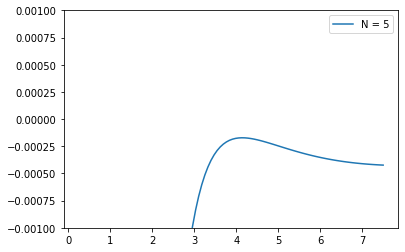

In [452]:
plt.figure()
plt.plot(Rho, U, label = 'N = 5')
#plt.ylim(0.5-0.5, +0.1)
plt.ylim(-0.001, 0.001)
plt.legend()
plt.show()

In [425]:
D = 1
m = 0
N = 5
Rho_length = 50
Rho = np.linspace(0.01, 30, Rho_length)
D_array = np.concatenate((np.linspace(0.01, 0.32, 5), np.linspace(0.32, 0.4, 20), np.linspace(0.4, 1, 10)))
barrierHeight = []
for D in D_array:
    print('Current D = ', D)
    U = []
    for rho in Rho:
        U += [effectivePotential(rho, D, m, N)]
    U = np.array(U)
    barrierHeight += [U.max()]
barrierHeight = np.array(barrierHeight)

Current D =  0.01
Current D =  0.0875
Current D =  0.165
Current D =  0.2425
Current D =  0.32
Current D =  0.32
Current D =  0.3242105263157895
Current D =  0.32842105263157895
Current D =  0.33263157894736844
Current D =  0.3368421052631579
Current D =  0.3410526315789474
Current D =  0.3452631578947368
Current D =  0.3494736842105263
Current D =  0.3536842105263158
Current D =  0.35789473684210527
Current D =  0.36210526315789476
Current D =  0.3663157894736842
Current D =  0.3705263157894737
Current D =  0.37473684210526315
Current D =  0.37894736842105264
Current D =  0.38315789473684214
Current D =  0.3873684210526316
Current D =  0.3915789473684211
Current D =  0.3957894736842106
Current D =  0.4
Current D =  0.4
Current D =  0.4666666666666667
Current D =  0.5333333333333333
Current D =  0.6000000000000001
Current D =  0.6666666666666667
Current D =  0.7333333333333334
Current D =  0.8
Current D =  0.8666666666666667
Current D =  0.9333333333333333
Current D =  1.0


In [462]:
barrierHeight

array([-8.9575e-05])

<ipython-input-461-27a13d026b28>:8: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.savefig('barrier_height_diag.jpg', dpi = 300)


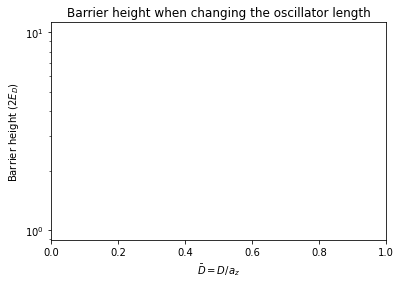

In [461]:
plt.figure()
plt.semilogy(D_array, barrierHeight)
plt.title('Barrier height when changing the oscillator length')
plt.xlabel(r'$\bar D=D/a_z$')
plt.ylabel(r'Barrier height ($2E_D$)')
#plt.plot(D_array, np.log(barrierHeight1))
plt.xlim(0, 1)
plt.savefig('barrier_height_diag.jpg', dpi = 300)
plt.show()

In [459]:
D = 1
m = 0
N = 9
Rho_length = 30
Rho = np.linspace(2.5, 7.5, Rho_length)
D_array = np.linspace(0.345, 0.35, 1)
barrierHeight = []
for D in D_array:
    print('Current D = ', D)
    U = []
    for rho in Rho:
        U += [effectivePotential(rho, D, m, N)]
    U = np.array(U)
    barrierHeight += [U.max()]
barrierHeight = np.array(barrierHeight)

Current D =  0.345


In [460]:
barrierHeight

array([-8.9575e-05])

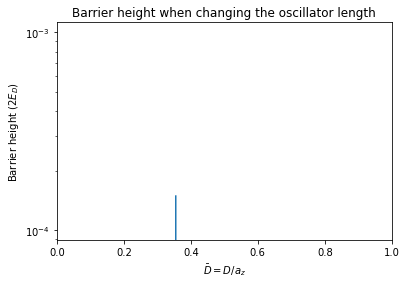

In [439]:
plt.figure()
plt.semilogy(D_array, barrierHeight)
plt.title('Barrier height when changing the oscillator length')
plt.xlabel(r'$\bar D=D/a_z$')
plt.ylabel(r'Barrier height ($2E_D$)')
#plt.plot(D_array, np.log(barrierHeight1))
plt.xlim(0, 1)
plt.show()

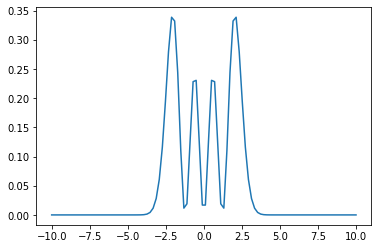

In [77]:
x = np.linspace(-10, 10, 100)
plt.figure()
plt.plot(x, harmonicOscillatorProba(x, 1, 3))
plt.show()

In [78]:
quad(harmonicOscillatorProba, -np.infty, np.infty, args = (1, 0,))

(1.0, 8.012979813683995e-09)

In [1009]:
from scipy.optimize import root
from scipy.integrate import quad
from scipy.signal import argrelextrema

import numpy as np
import matplotlib.pyplot as plt
# 100 a_0 / a_dd = 5 / 3.5
# a_dd_Dy = 6.96
# a_vdw_Dy = 4.26

hbar = 6.62*10**(-34)/(2*np.pi)
m_Dy = 162*1.66*10**(-27)
k_B = 1.38*10**(-23)
nm_to_uK = hbar**2/(m_Dy*10**(-18)*k_B)*10**6


#a_dd_Dy = 6.96
a_dd_Dy = 20.86
#a_vdw_Dy = 4.26
#a_dd_Dy = 1
#a_vdw_Dy = 4.26/6.96
#a_dd_Dy = 1
#a_vdw_Dy = 0*4.26/6.96
#a_dd_Dy = 10
a_vdw_Dy = 0

"""
def V(rho, z, m, a_z, a_dd = a_dd_Dy, r_vdw = a_vdw_Dy):
    return (1/a_z)**4*z**2 + m**2/rho**2-(2*r_vdw)**4/(z**2+rho**2)**3+3*a_dd*(1-3*(z**2/(z**2+rho**2)))/(z**2+rho**2)**(3/2)

def dVdz(rho, z, m, a_z, a_dd = a_dd_Dy, r_vdw = a_vdw_Dy):
    return z*(2/(a_z**4) + 6*(2*r_vdw)**4/(z**2+rho**2)**4 + 9*a_dd*(2*z**2-3*rho**2)/((z**2+rho**2)**(7/2)))

def dVdrho(rho, z, m, a_z, a_dd = a_dd_Dy, r_vdw = a_vdw_Dy):
    return -2*m**2/rho**3 + 6*(2*r_vdw)**4*rho/(z**2+rho**2)**4 - 9*a_dd*rho*(-4*z**2+rho**2)/(z**2+rho**2)**(7/2)

def derivativeV(rho, z, m, a_z, a_dd = a_dd_Dy, r_vdw = a_vdw_Dy):
    return [dVdz(rho, z, m, a_z, a_dd, r_vdw), dVdrho(rho, z, m, a_z, a_dd, r_vdw)]
"""
def V(rho, z, m, a_z, a_dd = a_dd_Dy, r_vdw = a_vdw_Dy):
    return (1/a_z)**4*z**2 + (m**2-1/4)/rho**2-(2*r_vdw)**4/(z**2+rho**2)**3+a_dd*(1-3*(z**2/(z**2+rho**2)))/(z**2+rho**2)**(3/2)

def dVdrho(rho, z, m, a_z, a_dd = a_dd_Dy, r_vdw = a_vdw_Dy):
    return -2*(m**2-1/4)/rho**3 + 6*rho*(2*r_vdw)**4/(z**2+rho**2)**4 - 3*a_dd*rho*(-4*z**2+rho**2)/(z**2+rho**2)**(7/2)

def dVdz(rho, z, m, a_z, a_dd = a_dd_Dy, r_vdw = a_vdw_Dy):
    return z*(2/(a_z**4) + 6*(2*r_vdw)**4/(z**2+rho**2)**4 + 3*a_dd*(2*z**2-3*rho**2)/((z**2+rho**2)**(7/2)))

def derivativeV(rho, z, m, a_z, a_dd = a_dd_Dy, r_vdw = a_vdw_Dy):
    return [dVdrho(rho, z, m, a_z, a_dd, r_vdw), dVdz(rho, z, m, a_z, a_dd, r_vdw)]

def d2Vdrho2(rho, z, m, a_z, a_dd = a_dd_Dy, r_vdw = a_vdw_Dy):
    return 6*(m**2-1/4)/rho**4 + 6*(2*r_vdw)**4*(z**2-7*rho**2)/(z**2+rho**2)**5 + 3*a_dd*rho*(4*z**4-27*z**2*rho**2+4*rho**4)/(z**2+rho**2)**(9/2)

def d2Vdz2(rho, z, m, a_z, a_dd = a_dd_Dy, r_vdw = a_vdw_Dy):
    return 2/(a_z**4) + 6*(2*r_vdw)**4*(-7*z**2+rho**2)/(z**2+rho**2)**5 - 3*a_dd*(8*z**4-24*z**2*rho**2+3*rho**4)/((z**2+rho**2)**(9/2))

def d2Vdzdrho(rho, z, m, a_z, a_dd = a_dd_Dy, r_vdw = a_vdw_Dy):
    return -3*z*rho*(16*(2*r_vdw)**4*np.sqrt(z**2+rho**2)+5*a_dd*(4*z**4+z**2*rho**2-3*rho**4))/(z**2+rho**2)**(11/2)

def Jac(rho, z, m, a_z, a_dd = a_dd_Dy, r_vdw = a_vdw_Dy):
    return np.array([[d2Vdrhodrho(rho, z, m, a_z, a_dd, r_vdw), d2Vdzdrho(rho, z, m, a_z, a_dd, r_vdw)],
                     [d2Vdzdrho(rho, z, m, a_z, a_dd, r_vdw), d2Vdz2(rho, z, m, a_z, a_dd, r_vdw)]]
                    )

def Jac(rho, z, m, a_z, a_dd = a_dd_Dy, r_vdw = a_vdw_Dy):
    return np.array([[d2Vdrho2(rho, z, m, a_z, a_dd, r_vdw), d2Vdzdrho(rho, z, m, a_z, a_dd, r_vdw)],
                     [d2Vdzdrho(rho, z, m, a_z, a_dd, r_vdw), d2Vdz2(rho, z, m, a_z, a_dd, r_vdw)]]
                    )



"""
def V(rho, z, m, a_z, a_dd = a_dd_Dy, r_vdw = a_vdw_Dy):
    return (1/a_z)**4*z**2 + m**2/rho**2-(2*r_vdw)**4/(z**2+rho**2)**3+a_dd*(1-3*(z**2/(z**2+rho**2)))/(z**2+rho**2)**(3/2)

def dVdrho(rho, z, m, a_z, a_dd = a_dd_Dy, r_vdw = a_vdw_Dy):
    return -2*m**2/rho**3 + 6*rho*(2*r_vdw)**4/(z**2+rho**2)**4 - 3*a_dd*rho*(-4*z**2+rho**2)/(z**2+rho**2)**(7/2)

def dVdz(rho, z, m, a_z, a_dd = a_dd_Dy, r_vdw = a_vdw_Dy):
    return z*(2/(a_z**4) + 6*(2*r_vdw)**4/(z**2+rho**2)**4 + 3*a_dd*(2*z**2-3*rho**2)/((z**2+rho**2)**(7/2)))

def derivativeV(rho, z, m, a_z, a_dd = a_dd_Dy, r_vdw = a_vdw_Dy):
    return [dVdrho(rho, z, m, a_z, a_dd, r_vdw), dVdz(rho, z, m, a_z, a_dd, r_vdw)]

def d2Vdrho2(rho, z, m, a_z, a_dd = a_dd_Dy, r_vdw = a_vdw_Dy):
    return 6*m**2/rho**4 + 6*(2*r_vdw)**4*(z**2-7*rho**2)/(z**2+rho**2)**5 + 3*a_dd*rho*(4*z**4-27*z**2*rho**2+4*rho**4)/(z**2+rho**2)**(9/2)

def d2Vdz2(rho, z, m, a_z, a_dd = a_dd_Dy, r_vdw = a_vdw_Dy):
    return 2/(a_z**4) + 6*(2*r_vdw)**4*(-7*z**2+rho**2)/(z**2+rho**2)**5 - 3*a_dd*(8*z**4-24*z**2*rho**2+3*rho**4)/((z**2+rho**2)**(9/2))

def d2Vdzdrho(rho, z, m, a_z, a_dd = a_dd_Dy, r_vdw = a_vdw_Dy):
    return -3*z*rho*(16*(2*r_vdw)**4*np.sqrt(z**2+rho**2)+5*a_dd*(4*z**4+z**2*rho**2-3*rho**4))/(z**2+rho**2)**(11/2)

def Jac(rho, z, m, a_z, a_dd = a_dd_Dy, r_vdw = a_vdw_Dy):
    return np.array([[d2Vdrhodrho(rho, z, m, a_z, a_dd, r_vdw), d2Vdzdrho(rho, z, m, a_z, a_dd, r_vdw)],
                     [d2Vdzdrho(rho, z, m, a_z, a_dd, r_vdw), d2Vdz2(rho, z, m, a_z, a_dd, r_vdw)]]
                    )

def Jac(rho, z, m, a_z, a_dd = a_dd_Dy, r_vdw = a_vdw_Dy):
    return np.array([[d2Vdrho2(rho, z, m, a_z, a_dd, r_vdw), d2Vdzdrho(rho, z, m, a_z, a_dd, r_vdw)],
                     [d2Vdzdrho(rho, z, m, a_z, a_dd, r_vdw), d2Vdz2(rho, z, m, a_z, a_dd, r_vdw)]]
                    )

"""


"""
def d2Vdz2()

def fun(x):
...     return [x[0]  + 0.5 * (x[0] - x[1])**3 - 1.0,
...             0.5 * (x[1] - x[0])**3 + x[1]]
>>> def jac(x):
...     return np.array([[1 + 1.5 * (x[0] - x[1])**2,
...                       -1.5 * (x[0] - x[1])**2],
...                      [-1.5 * (x[1] - x[0])**2,
...                       1 + 1.5 * (x[1] - x[0])**2]])"""

'\ndef d2Vdz2()\n\ndef fun(x):\n...     return [x[0]  + 0.5 * (x[0] - x[1])**3 - 1.0,\n...             0.5 * (x[1] - x[0])**3 + x[1]]\n>>> def jac(x):\n...     return np.array([[1 + 1.5 * (x[0] - x[1])**2,\n...                       -1.5 * (x[0] - x[1])**2],\n...                      [-1.5 * (x[1] - x[0])**2,\n...                       1 + 1.5 * (x[1] - x[0])**2]])'

In [1010]:
derivativeV(1,1,1,1)

[15.094028387495303, -3.531342795831767]

In [1011]:
epsilon = 0.00001
def SaddlePosition(m, a_z, a_dd = a_dd_Dy, r_vdw = a_vdw_Dy):
    def currentDerivativeV(r):
        rho, z = r
        return derivativeV(rho, z, m, a_z, a_dd, r_vdw)
    def currentJac(r):
        rho, z = r
        return Jac(rho, z, m, a_z, a_dd, r_vdw)
    #sol = root(currentDerivativeV, [epsilon, epsilon], jac = currentJac, method='lm')
    sol = root(currentDerivativeV, [epsilon, epsilon], method='lm')
    return sol.x

In [1012]:
NbIteration = 300
azList = 0.001 + np.array(list(range(NbIteration)))/3
SaddlePosition_M0 = []
SaddleHeight_M0 = []
m = 0

for a_z in azList:
    result_M0 = SaddlePosition(m, a_z)
    SaddlePosition_M0 += [result_M0]
    SaddleHeight_M0 += [V(result_M0[0],result_M0[1], m, a_z)]
SaddlePosition_M0 = np.array(SaddlePosition_M0)
SaddleHeight_M0 = np.array(SaddleHeight_M0)

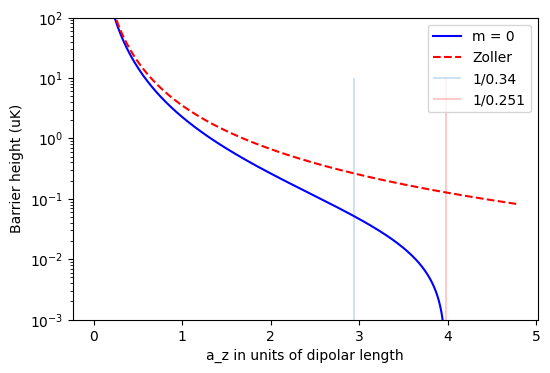

In [1013]:
saddleHeight_uK = SaddleHeight_M0*nm_to_uK
plt.figure(dpi = 100)
plt.semilogy(azList/a_dd_Dy, saddleHeight_uK, label = "m = 0", color = 'blue')
#plt.semilogy(azList/a_dd_Dy, nm_to_uK*0.34/(azList**2), '--', label = "Zoller", color = 'red')
plt.semilogy(azList/a_dd_Dy, 0.51*nm_to_uK/(azList**2)*(a_dd_Dy/azList)**(2/5), '--', label = "Zoller", color = 'red')
plt.vlines(1/0.34, 0.00000001, 10, lw = 0.3, label = '1/0.34')
plt.vlines(1/0.251, 0.00000001, 10, lw = 0.3, color = 'red', label = '1/0.251')
plt.legend()
plt.xlabel("a_z in units of dipolar length")
#plt.ylabel("Barrier height (Energy unit 1nm)")
plt.ylabel("Barrier height (uK)")
#plt.xlim(0,10)
plt.ylim(10**(-3),10**2)
plt.savefig('barrier_height.jpg', dpi = 300)
plt.show()

In [1014]:
a_dd_Dy

20.86

In [1015]:
a_z = 3.9*a_dd_Dy*10**(-9)
hbar/(m_Dy*a_z**2)/(2*np.pi*1000)

9.42144089426282

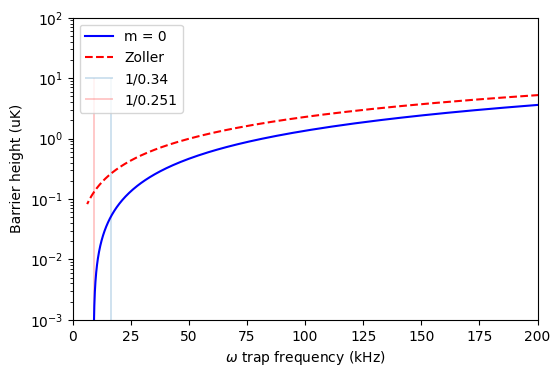

In [1016]:
saddleHeight_uK = SaddleHeight_M0*nm_to_uK
plt.figure(dpi = 100)
plt.semilogy(hbar/(m_Dy*(azList*10**(-9))**2)/(2*np.pi*10**3), saddleHeight_uK, label = "m = 0", color = 'blue')
plt.semilogy(hbar/(m_Dy*(azList*10**(-9))**2)/(2*np.pi*10**3), 0.51*nm_to_uK/(azList**2)*(a_dd_Dy/azList)**(2/5), '--', label = "Zoller", color = 'red')
plt.vlines(hbar/(m_Dy*(a_dd_Dy/0.34*10**(-9))**2)/(2*np.pi*10**3), 0.00000001, 10, lw = 0.3, label = '1/0.34')
plt.vlines(hbar/(m_Dy*(a_dd_Dy/0.251*10**(-9))**2)/(2*np.pi*10**3), 0.00000001, 10, lw = 0.3, color = 'red', label = '1/0.251')
plt.legend()
plt.xlabel("$\omega$ trap frequency (kHz)")
#plt.ylabel("Barrier height (Energy unit 1nm)")
plt.ylabel("Barrier height (uK)")
plt.xlim(0,200)
plt.ylim(10**(-3),10**2)
plt.savefig('barrier_height.jpg', dpi = 300)
plt.show()

In [1017]:
result_M0 = SaddlePosition(0, 0.001)
V(result_M0[0],result_M0[1], 0, a_z)
result_M0

array([0.0081441 , 0.00407176])

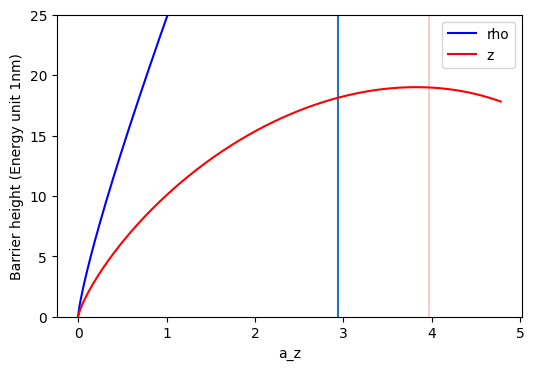

In [1018]:
plt.figure(dpi = 100)
plt.plot(azList/a_dd_Dy, SaddlePosition_M0[:,0], label = "rho", color = 'blue')
plt.plot(azList/a_dd_Dy, SaddlePosition_M0[:,1], label = "z", color = 'red')
plt.vlines(1/0.34, 0, 100)
plt.vlines(1/0.252, 0, 100, lw = 0.3, color = 'red')
plt.legend()
plt.xlabel("a_z")
plt.ylabel("Barrier height (Energy unit 1nm)")
#plt.xlim(0,10)
plt.ylim(0,25)
plt.show()

In [1019]:
SaddlePosition(0, 5, a_dd = a_dd_Dy, r_vdw = a_vdw_Dy)

array([7.57805981, 3.551754  ])

In [1020]:
NbIteration = 150
azList = 0.0 + np.array(list(range(NbIteration)))/2
SaddlePosition_M0 = [] 
SaddlePosition_M1 = []
SaddlePosition_M2 = []
SaddleHeight_M0 = [] 
SaddleHeight_M1 = [] 
SaddleHeight_M2 = [] 

for a_z in azList:
    result_M0 = SaddlePosition(0, a_z)
    result_M1 = SaddlePosition(1, a_z)
    result_M2 = SaddlePosition(2, a_z)
    SaddlePosition_M0 += [result_M0]
    SaddlePosition_M1 += [result_M1]
    SaddlePosition_M2 += [result_M2]
    SaddleHeight_M0 += [V(result_M0[0],result_M0[1], 0, a_z)]
    SaddleHeight_M1 += [V(result_M1[0],result_M1[1], 1, a_z)]
    SaddleHeight_M2 += [V(result_M2[0],result_M2[1], 2, a_z)]
SaddlePosition_M0 = np.array(SaddlePosition_M0)
SaddlePosition_M1 = np.array(SaddlePosition_M1)
SaddlePosition_M2 = np.array(SaddlePosition_M2)
SaddleHeight_M0 = np.array(SaddleHeight_M0)
SaddleHeight_M1 = np.array(SaddleHeight_M1)
SaddleHeight_M2 = np.array(SaddleHeight_M2)


SaddlePosition_M0_noC6 = [] 
SaddlePosition_M1_noC6 = []
SaddlePosition_M2_noC6 = []
SaddleHeight_M0_noC6 = [] 
SaddleHeight_M1_noC6 = [] 
SaddleHeight_M2_noC6 = [] 

for a_z in azList:
    result_M0_noC6 = SaddlePosition(0, a_z, r_vdw = 0)
    result_M1_noC6 = SaddlePosition(1, a_z, r_vdw = 0)
    result_M2_noC6 = SaddlePosition(2, a_z, r_vdw = 0)
    SaddlePosition_M0_noC6 += [result_M0_noC6]
    SaddlePosition_M1_noC6 += [result_M1_noC6]
    SaddlePosition_M2_noC6 += [result_M2_noC6]
    SaddleHeight_M0_noC6 += [V(result_M0_noC6[0],result_M0_noC6[1], 0, a_z, r_vdw = 0)]
    SaddleHeight_M1_noC6 += [V(result_M1_noC6[0],result_M1_noC6[1], 1, a_z, r_vdw = 0)]
    SaddleHeight_M2_noC6 += [V(result_M2_noC6[0],result_M2_noC6[1], 2, a_z, r_vdw = 0)]
SaddlePosition_M0_noC6 = np.array(SaddlePosition_M0_noC6)
SaddlePosition_M1_noC6 = np.array(SaddlePosition_M1_noC6)
SaddlePosition_M2_noC6 = np.array(SaddlePosition_M2_noC6)
SaddleHeight_M0_noC6 = np.array(SaddleHeight_M0_noC6)
SaddleHeight_M1_noC6 = np.array(SaddleHeight_M1_noC6)
SaddleHeight_M2_noC6 = np.array(SaddleHeight_M2_noC6)

<ipython-input-1009-c4185b1dea06>:47: RuntimeWarning: divide by zero encountered in double_scalars
  return z*(2/(a_z**4) + 6*(2*r_vdw)**4/(z**2+rho**2)**4 + 3*a_dd*(2*z**2-3*rho**2)/((z**2+rho**2)**(7/2)))
<ipython-input-1009-c4185b1dea06>:41: RuntimeWarning: divide by zero encountered in double_scalars
  return (1/a_z)**4*z**2 + (m**2-1/4)/rho**2-(2*r_vdw)**4/(z**2+rho**2)**3+a_dd*(1-3*(z**2/(z**2+rho**2)))/(z**2+rho**2)**(3/2)


In [1021]:
azList

array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
        5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5,
       11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. ,
       16.5, 17. , 17.5, 18. , 18.5, 19. , 19.5, 20. , 20.5, 21. , 21.5,
       22. , 22.5, 23. , 23.5, 24. , 24.5, 25. , 25.5, 26. , 26.5, 27. ,
       27.5, 28. , 28.5, 29. , 29.5, 30. , 30.5, 31. , 31.5, 32. , 32.5,
       33. , 33.5, 34. , 34.5, 35. , 35.5, 36. , 36.5, 37. , 37.5, 38. ,
       38.5, 39. , 39.5, 40. , 40.5, 41. , 41.5, 42. , 42.5, 43. , 43.5,
       44. , 44.5, 45. , 45.5, 46. , 46.5, 47. , 47.5, 48. , 48.5, 49. ,
       49.5, 50. , 50.5, 51. , 51.5, 52. , 52.5, 53. , 53.5, 54. , 54.5,
       55. , 55.5, 56. , 56.5, 57. , 57.5, 58. , 58.5, 59. , 59.5, 60. ,
       60.5, 61. , 61.5, 62. , 62.5, 63. , 63.5, 64. , 64.5, 65. , 65.5,
       66. , 66.5, 67. , 67.5, 68. , 68.5, 69. , 69.5, 70. , 70.5, 71. ,
       71.5, 72. , 72.5, 73. , 73.5, 74. , 74.5])

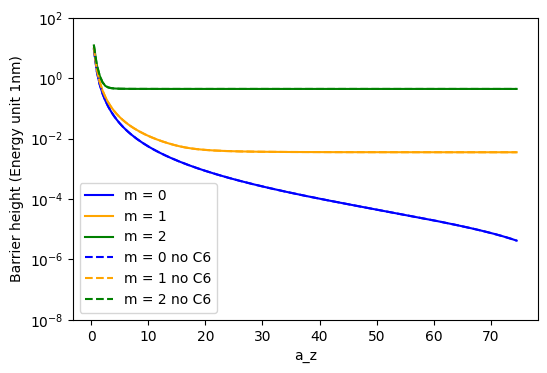

In [1022]:
plt.figure(dpi = 100)
plt.semilogy(azList, SaddleHeight_M0, label = "m = 0", color = 'blue')
plt.semilogy(azList, SaddleHeight_M1, label = "m = 1", color = 'orange')
plt.semilogy(azList, SaddleHeight_M2, label = "m = 2", color = 'green')
plt.semilogy(azList, SaddleHeight_M0_noC6, '--', label = "m = 0 no C6", color = 'blue')
plt.semilogy(azList, SaddleHeight_M1_noC6, '--', label = "m = 1 no C6", color = 'orange')
plt.semilogy(azList, SaddleHeight_M2_noC6, '--', label = "m = 2 no C6", color = 'green')
plt.legend()
plt.xlabel("a_z")
plt.ylabel("Barrier height (Energy unit 1nm)")
#plt.xlim(0,10)
plt.ylim(10**(-8),100)
plt.show()

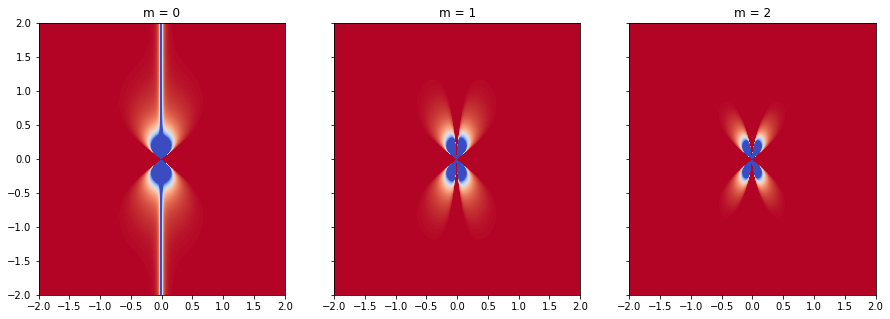

In [1023]:
rho_lim = 2
z_lim = 2
rho, z = np.meshgrid(np.linspace(-rho_lim, rho_lim, 1000), np.linspace(-z_lim, z_lim, 1000))
potential_0 = V(rho, z, 0, 10)
potential_1 = V(rho, z, 1, 10)
potential_2 = V(rho, z, 2, 10)

fig = plt.figure(figsize = (15,5))
gs = fig.add_gridspec(1, 3, hspace=1)
ax1, ax2, ax3 = gs.subplots(sharex=True, sharey=True)
c1 = ax1.pcolormesh(rho, z, potential_0, cmap='coolwarm', shading='nearest', vmin=-1000, vmax=-10)
c2 = ax2.pcolormesh(rho, z, potential_1, cmap='coolwarm', shading='nearest', vmin=-1000, vmax=-10)
c2 = ax3.pcolormesh(rho, z, potential_2, cmap='coolwarm', shading='nearest', vmin=-1000, vmax=-10)
ax1.set_title('m = 0')
ax2.set_title('m = 1')
ax3.set_title('m = 2')
ax1.axis([-rho_lim, rho_lim, -z_lim, z_lim])
#fig.colorbar(c1)
#cbaxes = fig.add_axes([1, 1, 1, 1]) 
#cb = plt.colorbar(ax, cax = cbaxes)

plt.show()

In [1024]:
potential_0.min()

-459626154.7243841

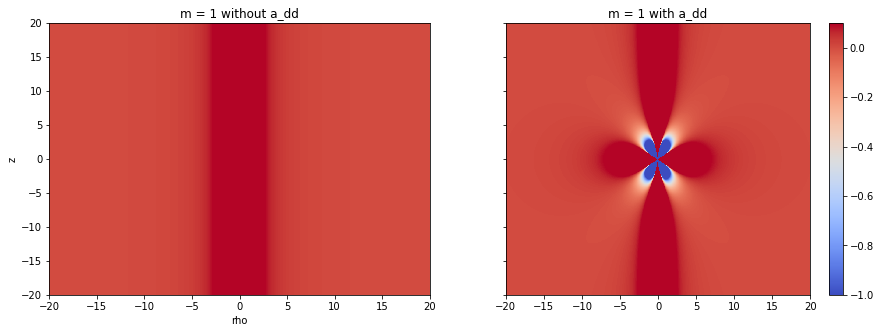

In [1025]:
#def V(rho, z, m, a_z, a_dd = a_dd_Dy, r_vdw = a_vdw_Dy):
#    return (1/a_z)**4*z**2 + m**2/rho**2-(2*r_vdw)**4/(z**2+rho**2)**3+3*a_dd*(1-3*(z**2/(z**2+rho**2)))/(z**2+rho**2)**(3/2)



rho_lim = 20
z_lim = 20
rho, z = np.meshgrid(np.linspace(-rho_lim, rho_lim, 1000), np.linspace(-z_lim, z_lim, 1000))
potential_0 = V(rho, z, 1, np.infty, a_dd = 0)
potential_1 = V(rho, z, 1, np.infty, a_dd = 30)
fig = plt.figure(figsize = (15,5))
gs = fig.add_gridspec(1, 2, hspace=1)
ax1, ax2 = gs.subplots(sharex=True, sharey=True)
c1 = ax1.pcolormesh(rho, z, potential_0, cmap='coolwarm', shading='nearest', vmin=-1, vmax=0.1)
c2 = ax2.pcolormesh(rho, z, potential_1, cmap='coolwarm', shading='nearest', vmin=-1, vmax=0.1)
ax1.set_title('m = 1 without a_dd')
ax2.set_title('m = 1 with a_dd')
ax1.set_xlabel('rho')
ax1.set_ylabel('z')
ax1.axis([-rho_lim, rho_lim, -z_lim, z_lim])
fig.colorbar(c1)
#cbaxes = fig.add_axes([1, 1, 1, 1]) 
#cb = plt.colorbar(ax3)#, cax = cbaxes)

plt.show()

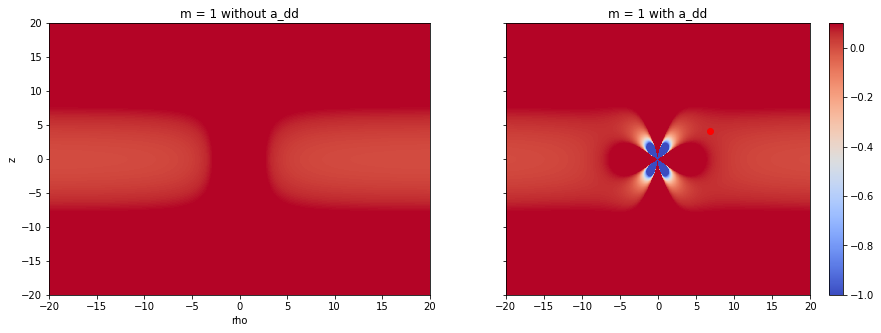

In [1026]:
def SaddlePosition(m, a_z, a_dd = a_dd_Dy, r_vdw = a_vdw_Dy):
    def currentDerivativeV(r):
        rho, z = r
        return derivativeV(rho, z, m, a_z, a_dd, r_vdw)
    sol = root(currentDerivativeV, [1, 1], method='lm')
    return sol.x

m = 1
a_z = 5

Saddle = SaddlePosition(m, a_z, a_dd = a_dd_Dy)

rho_lim = 20
z_lim = 20
rho, z = np.meshgrid(np.linspace(-rho_lim, rho_lim, 1000), np.linspace(-z_lim, z_lim, 1000))
potential_0 = V(rho, z, m, a_z, a_dd = 0)
potential_1 = V(rho, z, m, a_z, a_dd = a_dd_Dy)
fig = plt.figure(figsize = (15,5))
gs = fig.add_gridspec(1, 2, hspace=1)
ax1, ax2 = gs.subplots(sharex=True, sharey=True)
c1 = ax1.pcolormesh(rho, z, potential_0, cmap='coolwarm', shading='nearest', vmin=-1, vmax=0.1)
c2 = ax2.pcolormesh(rho, z, potential_1, cmap='coolwarm', shading='nearest', vmin=-1, vmax=0.1)
ax2.plot(Saddle[0], Saddle[1], 'ro')
ax1.set_title('m = '+str(m)+' without a_dd')
ax2.set_title('m = '+str(m)+' with a_dd')
ax1.set_xlabel('rho')
ax1.set_ylabel('z')
ax1.axis([-rho_lim, rho_lim, -z_lim, z_lim])
fig.colorbar(c1)
#cbaxes = fig.add_axes([1, 1, 1, 1]) 
#cb = plt.colorbar(ax3)#, cax = cbaxes)

plt.show()

In [1027]:
Saddle

array([6.79605138, 4.15473584])

In [1028]:
V(Saddle[0], Saddle[1], m, a_z, a_dd = a_dd_Dy, r_vdw = a_vdw_Dy)

0.051444405161696

In [1029]:
V(rho, z, 0, a_z, a_dd = 0)

array([[0.639375  , 0.63937249, 0.63936996, ..., 0.63936996, 0.63937249,
        0.639375  ],
       [0.636815  , 0.63681249, 0.63680997, ..., 0.63680997, 0.63681249,
        0.636815  ],
       [0.63426014, 0.63425763, 0.6342551 , ..., 0.6342551 , 0.63425763,
        0.63426014],
       ...,
       [0.63426014, 0.63425763, 0.6342551 , ..., 0.6342551 , 0.63425763,
        0.63426014],
       [0.636815  , 0.63681249, 0.63680997, ..., 0.63680997, 0.63681249,
        0.636815  ],
       [0.639375  , 0.63937249, 0.63936996, ..., 0.63936996, 0.63937249,
        0.639375  ]])

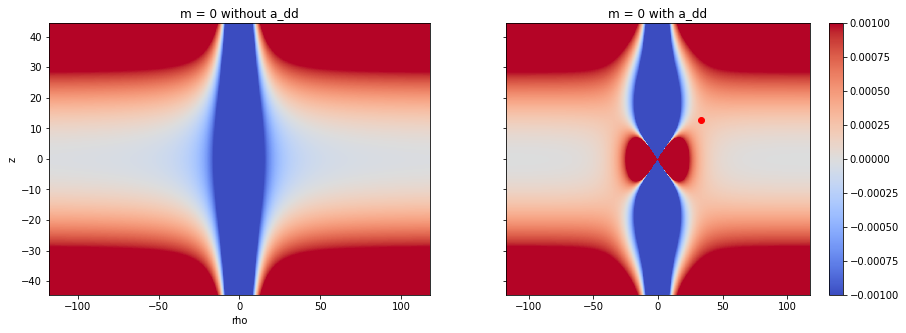

In [1046]:
#m = np.sqrt(1/4)
m = 0
a_z = 30

Saddle = SaddlePosition(m, a_z, a_dd = a_dd_Dy)

rho_lim = max(20, 3.5*Saddle[0])
z_lim = max(20, 3.5*Saddle[1])
#rho_lim = 10000
#z_lim = 10000

vmin = -1
vmax = 1
vmin = -1*10**(-3)
vmax = 1*10**(-3)
rho, z = np.meshgrid(np.linspace(-rho_lim, rho_lim, 1000), np.linspace(-z_lim, z_lim, 1000))
potential_0 = V(rho, z, m, a_z, a_dd = 0)
potential_1 = V(rho, z, m, a_z, a_dd = a_dd_Dy)
fig = plt.figure(figsize = (15,5))
gs = fig.add_gridspec(1, 2, hspace=1)
ax1, ax2 = gs.subplots(sharex=True, sharey=True)
c1 = ax1.pcolormesh(rho, z, potential_0, cmap='coolwarm', shading='nearest', vmin=vmin, vmax=vmax)
c2 = ax2.pcolormesh(rho, z, potential_1, cmap='coolwarm', shading='nearest', vmin=vmin, vmax=vmax)
ax2.plot(Saddle[0], Saddle[1], 'ro')
ax1.set_title('m = '+str(m)+' without a_dd')
ax2.set_title('m = '+str(m)+' with a_dd')
ax1.set_xlabel('rho')
ax1.set_ylabel('z')
ax1.axis([-rho_lim, rho_lim, -z_lim, z_lim])
fig.colorbar(c1)
#cbaxes = fig.add_axes([1, 1, 1, 1]) 
#cb = plt.colorbar(ax3)#, cax = cbaxes)

plt.show()

In [1047]:
Saddle

array([33.64657471, 12.71370362])

In [1048]:
V(Saddle[0],Saddle[1], 0, a_z)

0.0002589789747872019

In [1050]:
NbIteration = 50
azList = 0.001 + np.array(list(range(NbIteration)))/2
NbIteration = 300
azList = 0.001 + np.array(list(range(NbIteration)))/2
SaddlePosition_M0 = [] 
SaddleHeight_M0 = [] 

for a_z in azList:
    result_M0 = SaddlePosition(0, a_z)
    SaddlePosition_M0 += [result_M0]
    SaddleHeight_M0 += [V(result_M0[0],result_M0[1], 0, a_z)]
SaddlePosition_M0 = np.array(SaddlePosition_M0)
SaddleHeight_M0 = np.array(SaddleHeight_M0)




NbIteration = 300
azList = 0.001 + np.array(list(range(NbIteration)))/2
SaddlePosition_M0 = [] 
SaddleHeight_M0 = [] 

for a_z in azList:
    result_M0 = SaddlePosition(0, a_z)
    SaddlePosition_M0 += [result_M0]
    SaddleHeight_M0 += [V(result_M0[0],result_M0[1], 0, a_z)]
SaddlePosition_M0 = np.array(SaddlePosition_M0)
SaddleHeight_M0 = np.array(SaddleHeight_M0)

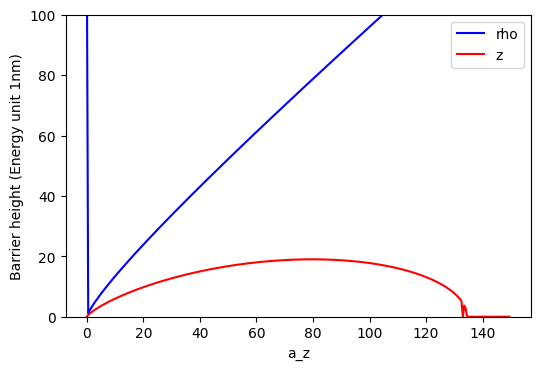

In [1051]:
plt.figure(dpi = 100)
plt.plot(azList, SaddlePosition_M0[:,0], label = "rho", color = 'blue')
plt.plot(azList, SaddlePosition_M0[:,1], label = "z", color = 'red')
plt.legend()
plt.xlabel("a_z")
plt.ylabel("Barrier height (Energy unit 1nm)")
#plt.xlim(0,10)
plt.ylim(0,100)
plt.show()

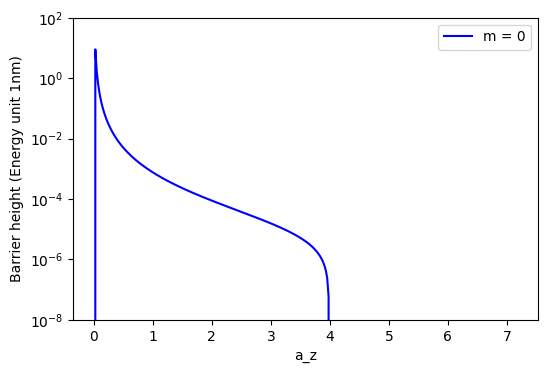

In [1052]:
plt.figure(dpi = 100)
plt.semilogy(azList/a_dd_Dy, SaddleHeight_M0, label = "m = 0", color = 'blue')
plt.legend()
plt.xlabel("a_z")
plt.ylabel("Barrier height (Energy unit 1nm)")
#plt.xlim(0,10)
plt.ylim(10**(-8),100)
plt.show()

## Integrating the potential along z

In [1053]:
def V(rho, z, m, a_z, a_dd = a_dd_Dy, r_vdw = a_vdw_Dy):
    return (1/a_z)**4*z**2 + (m**2-1/4)/rho**2-(2*r_vdw)**4/(z**2+rho**2)**3+a_dd*(1-3*(z**2/(z**2+rho**2)))/(z**2+rho**2)**(3/2)

def Psi0(z, a_z):
    return (np.pi*a_z**2)**(-1/4)*np.exp(-z**2/(2*a_z**2))

def prodVPsi0(z, rho, m, a_z, a_dd = a_dd_Dy, r_vdw = a_vdw_Dy):
    return V(rho, z, m, a_z, a_dd, r_vdw)*Psi0(z, a_z)**2

def intV(rho, m, a_z, a_dd = a_dd_Dy, r_vdw = a_vdw_Dy):
    return quad(prodVPsi0, a = -np.infty, b = np.infty, args = (rho, m, a_z, a_dd, r_vdw))
intV_all = np.vectorize(intV)

def findLocalMax(m, a_z, a_dd = a_dd_Dy, r_vdw = a_vdw_Dy, rho_min = 0.0001, rho_max = 10**2, n_points = 10**2):
    rho = np.linspace(rho_min, rho_max, n_points)
    integratedPotential = intV_all(rho, m, a_z, a_dd = a_dd_Dy, r_vdw = a_vdw_Dy)[0]
    result = argrelextrema(integratedPotential, np.greater) #np.less
    if result[0].size > 0: # not empty
        local_maxima = result[0][0]
        if (local_maxima > 0 and local_maxima < (n_points-1)):
            rho_min = rho[local_maxima - 1]
            rho_max = rho[local_maxima + 1]
            rho = np.linspace(rho_min, rho_max, n_points)
            integratedPotential = intV_all(rho, m, a_z, a_dd = a_dd_Dy, r_vdw = a_vdw_Dy)[0]
            local_maxima = argrelextrema(integratedPotential, np.greater)[0][0]
        else:
            print('Edge')
            return np.infty, 0
    else:
        print('No extrema found')
        return np.infty, 0
    return rho[local_maxima], integratedPotential[local_maxima]

In [1054]:
m = 0
A_z = np.linspace(1, 50, 100)
maxPotential = []
for a_z in A_z:
    result = findLocalMax(m, a_z)
    try:
        maxPotential += [result[1]]
    except:
        print(a_z, result)
        maxPotential += [0]
maxPotential = np.array(maxPotential)

No extrema found
No extrema found
No extrema found
No extrema found
No extrema found
No extrema found
No extrema found
No extrema found
No extrema found
No extrema found
No extrema found
No extrema found
No extrema found
No extrema found
No extrema found
No extrema found
No extrema found
No extrema found
No extrema found
No extrema found
No extrema found
No extrema found
No extrema found
No extrema found
No extrema found
No extrema found
No extrema found
No extrema found
No extrema found
No extrema found
No extrema found
No extrema found
No extrema found
No extrema found


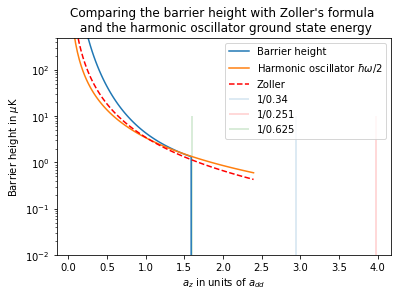

In [1063]:
#normalization_to_uK = A_z
plt.figure()
plt.semilogy(A_z/a_dd_Dy, nm_to_uK*maxPotential, label = 'Barrier height')
plt.semilogy(A_z/a_dd_Dy, nm_to_uK*0.5/A_z**2, label = 'Harmonic oscillator $\hbar\omega/2$')
plt.semilogy(A_z/a_dd_Dy, nm_to_uK*0.51/(A_z**2)*(a_dd_Dy/A_z)**(2/5), '--', label = "Zoller", color = 'red')
plt.vlines(1/0.34, 0.00000001, 10, lw = 0.3, label = '1/0.34')
plt.vlines(1/0.251, 0.00000001, 10, lw = 0.3, color = 'red', label = '1/0.251')
plt.vlines(1/0.625, 0.00000001, 10, lw = 0.3, color = 'green', label = '1/0.625')
plt.legend()
plt.title('Comparing the barrier height with Zoller\'s formula \n and the harmonic oscillator ground state energy')
plt.xlabel('$a_z$ in units of $a_{dd}$')
plt.ylabel('Barrier height in $\mu$K')
plt.ylim(0.01, 500)
plt.savefig('barrier_height.jpg', dpi = 300)
plt.show()

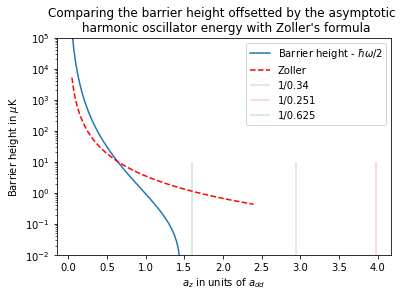

In [1064]:
#normalization_to_uK = A_z
plt.figure()
plt.semilogy(A_z/a_dd_Dy, nm_to_uK*(maxPotential-0.5/A_z**2), label = 'Barrier height - $\hbar\omega/2$')
plt.semilogy(A_z/a_dd_Dy, nm_to_uK*0.51/(A_z**2)*(a_dd_Dy/A_z)**(2/5), '--', label = "Zoller", color = 'red')
plt.vlines(1/0.34, 0.00000001, 10, lw = 0.3, label = '1/0.34')
plt.vlines(1/0.251, 0.00000001, 10, lw = 0.3, color = 'red', label = '1/0.251')
plt.vlines(1/0.625, 0.00000001, 10, lw = 0.3, color = 'green', label = '1/0.625')
plt.legend()
plt.title('Comparing the barrier height offsetted by the asymptotic \n harmonic oscillator energy with Zoller\'s formula')
plt.xlabel('$a_z$ in units of $a_{dd}$')
plt.ylabel('Barrier height in $\mu$K')
plt.ylim(0.01, 100000)
plt.savefig('barrier_height_substracted.jpg', dpi = 300)
plt.show()

In [942]:
rho = np.linspace(0.01, 1000, 100)
integratedPotential = intV_all(rho, 0, 20, a_dd = a_dd_Dy, r_vdw = a_vdw_Dy)[0]
local_maxima = argrelextrema(integratedPotential, np.greater)
local_maxima

(array([2]),)

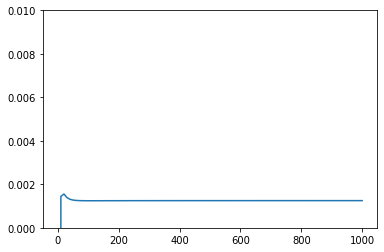

In [944]:
plt.figure()
plt.plot(rho, integratedPotential)
plt.ylim(0, 0.01)
plt.show()

In [930]:
integratedPotential - integratedPotential[12]

array([-2.49970284e+03,  4.87894250e-03,  1.09054892e-03,  3.43026976e-04,
        1.31628824e-04,  5.65804627e-05,  2.58032818e-05,  1.19724428e-05,
        5.42024251e-06,  2.26218854e-06,  7.81977723e-07,  1.64373787e-07,
        0.00000000e+00,  7.43741830e-08,  2.71546344e-07,  5.27493200e-07,
        8.06483613e-07,  1.08860989e-06,  1.36298913e-06,  1.62395305e-06,
        1.86886424e-06,  2.09684178e-06,  2.30800767e-06,  2.50303719e-06,
        2.68288965e-06,  2.84864773e-06,  3.00142266e-06,  3.14229972e-06,
        3.27230834e-06,  3.39240735e-06,  3.50347930e-06,  3.60633023e-06,
        3.70169250e-06,  3.79022936e-06,  3.87254019e-06,  3.94916606e-06,
        4.02059520e-06,  4.08726809e-06,  4.14958236e-06,  4.20789715e-06,
        4.26253710e-06,  4.31379600e-06,  4.36193996e-06,  4.40721034e-06,
        4.44982632e-06,  4.48998718e-06,  4.52787433e-06,  4.56365316e-06,
        4.59747463e-06,  4.62947671e-06,  4.65978566e-06,  4.68851718e-06,
        4.71577744e-06,  

In [809]:
quad(Psi0, -np.infty, np.infty, args = (1,))

(1.8827925275534287, 1.9163422831068328e-08)

In [813]:
intV(0.00001, 0, 10, a_dd = a_dd_Dy, r_vdw = a_vdw_Dy)

(-2499999999.378548, 4.792494105960941)

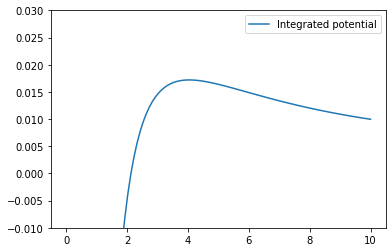

In [829]:
Rho = np.linspace(0.001, 10, 100)
integratedV = []
for rho in Rho:
    integratedV += [intV(rho, 0, 10, a_dd = a_dd_Dy, r_vdw = a_vdw_Dy)[0]]
integratedV = np.array(integratedV)
plt.figure()
plt.plot(Rho, integratedV, label = "Integrated potential")
plt.ylim(-0.01, 0.03)
plt.legend()
plt.show()

In [836]:
intV(10**(, 0, 10, a_dd = a_dd_Dy, r_vdw = a_vdw_Dy)

(0.004999999999750022, 7.970636037796637e-11)

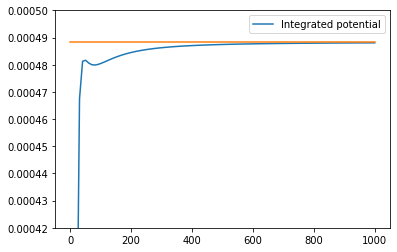

In [896]:
Rho = np.linspace(0.1, 1000, 100)
integratedV = []
for rho in Rho:
    integratedV += [intV(rho, 0, 32, a_dd = a_dd_Dy, r_vdw = a_vdw_Dy)[0]]
integratedV = np.array(integratedV)
plt.figure()
plt.plot(Rho, integratedV, label = "Integrated potential")
plt.plot(Rho, Rho*0 + 0.5/32**2)
plt.ylim(0.00042, 0.0005)
plt.legend()
plt.show()

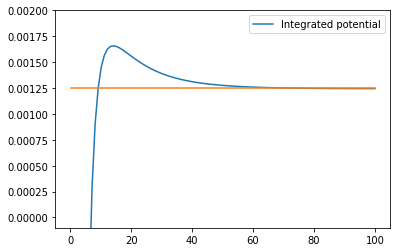

In [904]:
Rho = np.linspace(0.1, 100, 100)
integratedV = []
for rho in Rho:
    integratedV += [intV(rho, 0, 20, a_dd = a_dd_Dy, r_vdw = a_vdw_Dy)[0]]
integratedV = np.array(integratedV)
plt.figure()
plt.plot(Rho, integratedV, label = "Integrated potential")
plt.plot(Rho, Rho*0 + 0.5/20**2)
plt.ylim(-0.0001, 0.002)
plt.legend()
plt.show()

In [876]:
Rho

array([  0.1       ,   1.10909091,   2.11818182,   3.12727273,
         4.13636364,   5.14545455,   6.15454545,   7.16363636,
         8.17272727,   9.18181818,  10.19090909,  11.2       ,
        12.20909091,  13.21818182,  14.22727273,  15.23636364,
        16.24545455,  17.25454545,  18.26363636,  19.27272727,
        20.28181818,  21.29090909,  22.3       ,  23.30909091,
        24.31818182,  25.32727273,  26.33636364,  27.34545455,
        28.35454545,  29.36363636,  30.37272727,  31.38181818,
        32.39090909,  33.4       ,  34.40909091,  35.41818182,
        36.42727273,  37.43636364,  38.44545455,  39.45454545,
        40.46363636,  41.47272727,  42.48181818,  43.49090909,
        44.5       ,  45.50909091,  46.51818182,  47.52727273,
        48.53636364,  49.54545455,  50.55454545,  51.56363636,
        52.57272727,  53.58181818,  54.59090909,  55.6       ,
        56.60909091,  57.61818182,  58.62727273,  59.63636364,
        60.64545455,  61.65454545,  62.66363636,  63.67

In [845]:
prodVPsi0(0, Rho, 0, 10, a_dd = a_dd_Dy, r_vdw = a_vdw_Dy)

array([ 1.17689947e+30,  2.91526985e+29,  7.22134603e+28,  1.78878255e+28,
        4.43095096e+27,  1.09758039e+27,  2.71879042e+26,  6.73465147e+25,
        1.66822459e+25,  4.13231970e+24,  1.02360714e+24,  2.53555305e+23,
        6.28075850e+22,  1.55579184e+22,  3.85381518e+21,  9.54619445e+20,
        2.36466525e+20,  5.85745638e+19,  1.45093667e+19,  3.59408090e+18,
        8.90281279e+17,  2.20529469e+17,  5.46268326e+16,  1.35314833e+16,
        3.35185162e+15,  8.30279199e+14,  2.05666481e+14,  5.09451512e+13,
        1.26195004e+13,  3.12594560e+12,  7.74320197e+11,  1.91804869e+11,
        4.75114688e+10,  1.17689292e+10,  2.91524403e+09,  7.22124418e+08,
        1.78874238e+08,  4.43079252e+07,  1.09751789e+07,  2.71854394e+06,
        6.73367929e+05,  1.66784114e+05,  4.13080729e+04,  1.02301062e+04,
        2.53320024e+03,  6.27147853e+02,  1.55213162e+02,  3.83937854e+01,
        9.48925338e+00,  2.34220652e+00,  5.76887453e-01,  1.41599816e-01,
        3.45627622e-02,  

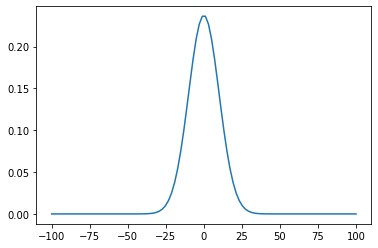

In [846]:
Z = np.linspace(-100, 100, 100)
plt.figure()
plt.plot(Z, Psi0(Z, 10))
plt.show()

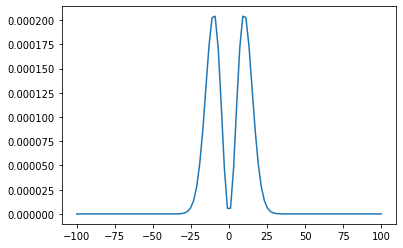

In [847]:
Z = np.linspace(-100, 100, 100)
plt.figure()
plt.plot(Z, prodVPsi0(Z, 10**9, 0, 10, a_dd = a_dd_Dy, r_vdw = a_vdw_Dy))
plt.show()

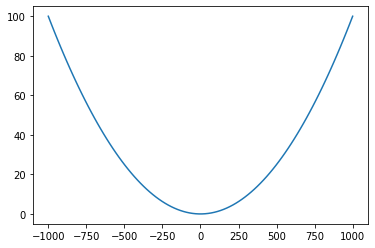

In [849]:
Z = np.linspace(-1000, 1000, 100)
plt.figure()
plt.plot(Z, V(10**9, Z, 0, 10, a_dd = a_dd_Dy, r_vdw = a_vdw_Dy))
plt.show()

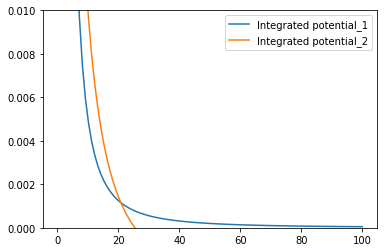

In [891]:
A_z = np.linspace(0.1, 100, 100)
integratedV_1 = []
for a_z in A_z:
    integratedV_1 += [intV(10**9, 0, a_z, a_dd = a_dd_Dy, r_vdw = a_vdw_Dy)[0]]
integratedV_2 = []
for a_z in A_z:
    integratedV_2 += [intV(10**1, 0, a_z, a_dd = a_dd_Dy, r_vdw = a_vdw_Dy)[0]]
integratedV_1 = np.array(integratedV_1)
integratedV_2 = np.array(integratedV_2)
plt.figure()
plt.plot(A_z, integratedV_1, label = "Integrated potential_1")
plt.plot(A_z, integratedV_2, label = "Integrated potential_2")
plt.ylim(0, 0.01)
plt.legend()
plt.show()